# Brain Tumor MRI

In [1]:
import os
import zipfile
import numpy as np
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.utils import Sequence
import shap
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Unzip dataset
dataset_path = 'Brain Tumor MRI.zip'  # Update with your dataset zip file name
extract_path = 'Brain_Tumor_MRI_Extracted'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")
else:
    print(f"Dataset already extracted at {extract_path}")

# Define paths
training_path = os.path.join(extract_path, 'Training')
testing_path = os.path.join(extract_path, 'Testing')

# Check the classes in the dataset
print("Training Classes:", os.listdir(training_path))
print("Testing Classes:", os.listdir(testing_path))


Dataset already extracted at Brain_Tumor_MRI_Extracted
Training Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Data Preprocessing

def crop_img(img):
    """
    Crop the brain region by finding contours in the image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return img[y:y+h, x:x+w]

def preprocess_images(source_dir, target_dir, img_size=256):
    """
    Preprocess images by cropping and resizing.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for subfolder in os.listdir(source_dir):
        subfolder_path = os.path.join(source_dir, subfolder)
        save_path = os.path.join(target_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)
        for img_name in tqdm(os.listdir(subfolder_path), desc=f"Processing {subfolder}"):
            img_path = os.path.join(subfolder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                cropped_img = crop_img(img)
                resized_img = cv2.resize(cropped_img, (img_size, img_size))
                cv2.imwrite(os.path.join(save_path, img_name), resized_img)

# Preprocess training and testing images
preprocess_images(training_path, 'Cleaned_Training')
preprocess_images(testing_path, 'Cleaned_Testing')

Processing pituitary: 100%|██████████| 300/300 [00:01<00:00, 156.19it/s]


In [4]:
# Improved Data Generators

# Load Data for Training

train_cleaned_path = 'Cleaned_Training'
test_cleaned_path = 'Cleaned_Testing'

# Create data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,  # Rotate images up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift up to 20%
    height_shift_range=0.2,  # Vertical shift up to 20%
    horizontal_flip=True,  # Flip images horizontally
    zoom_range=0.2,  # Randomly zoom in
    shear_range=0.2  # Apply shearing
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0  # Normalize test data
)

# Load data using the generators
train_generator = train_datagen.flow_from_directory(
    train_cleaned_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_cleaned_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


Class Distribution in Training Set:
Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})


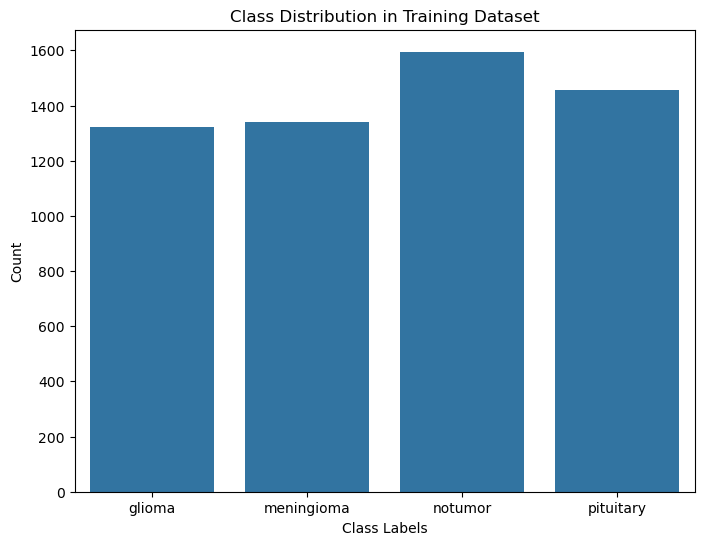

In [5]:
# Check class distribution for imbalance
class_counts = Counter(train_generator.classes)  # Get the class labels from the generator
class_labels = list(train_generator.class_indices.keys())  # Get class labels
print(f"Class Distribution in Training Set:\n{class_counts}")

# Visualize Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_generator.classes)
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution in Training Dataset')
plt.show()

In [6]:
# Leverage Transfer Learning

# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze initial layers of the base model
for layer in base_model.layers[:-20]:  # Fine-tune the last 20 layers
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flatten feature maps
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(4, activation='softmax')  # Output for 4 classes
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 9,194,116 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [8]:
# Create a custom data generator that applies class weights

from sklearn.utils import class_weight

# Calculate class weights based on the class distribution in the training data
class_counts = Counter(train_generator.classes)  # Get the class labels from the generator
class_labels = list(train_generator.class_indices.keys())  # Get class labels

# Calculate the class weights
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

# Convert the class weights into a dictionary (for the WeightedDataGenerator)
class_weights_dict = dict(zip(np.unique(train_generator.classes), class_weights))

print("Class Weights:", class_weights_dict)

# Create a custom data generator that applies class weights
class WeightedDataGenerator(Sequence):
    def __init__(self, generator, class_weights):
        self.generator = generator
        self.class_weights = class_weights

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        data, labels = self.generator[index]
        weights = np.array([self.class_weights[np.argmax(label)] for label in labels])
        return data, labels, weights

# Wrap the original generators with WeightedDataGenerator
train_generator_weighted = WeightedDataGenerator(train_generator, class_weights_dict)
test_generator_weighted = WeightedDataGenerator(test_generator, class_weights_dict)

# Now you can use `train_generator_weighted` and `test_generator_weighted` in your model training


Class Weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


In [9]:
# Custom training loop to handle weighted loss
def train_with_weights(model, train_gen, val_gen, epochs):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )
    return history

# Train the model with the weighted generator
history = train_with_weights(model, train_generator, test_generator, epochs=20)

# Save the model
model.save('brain_tumor_resnet_model_with_manual_weights.h5')
print("Model saved as 'brain_tumor_resnet_model_with_manual_weights.h5'")



C:\Users\milto\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 800s 4s/step - accuracy: 0.4479 - loss: 1.1944 - val_accuracy: 0.3982 - val_loss: 1.2003
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.5648 - loss: 0.9769 - val_accuracy: 0.3745 - val_loss: 1.4589
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 6610s 37s/step - accuracy: 0.6034 - loss: 0.9028 - val_accuracy: 0.5744 - val_loss: 0.9610
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 790s 4s/step - accuracy: 0.6143 - loss: 0.8910 - val_accuracy: 0.6140 - val_loss: 0.9398
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 789s 4s/step - accuracy: 0.6309 - loss: 0.8799 - val_accuracy: 0.6697 - val_loss: 0.8057
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 803s 4s/step - accuracy: 0.6470 - loss: 0.8346 - val_accuracy: 0.4897 - val_loss: 1.3101
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 803s 4s/step - accuracy: 0.6560 - loss: 0.8040 - val_accuracy: 0.5774 - val_loss: 1.0115
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 767s 4s/step - accuracy: 0.6809 - loss: 0.7800 - val_ac

Model saved as 'brain_tumor_resnet_model_with_manual_weights.h5'


41/41 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6183 - loss: 2.6324
Test Accuracy: 48.82%
41/41 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.36      0.93      0.52       300
  meningioma       0.36      0.05      0.09       306
     notumor       0.88      0.53      0.66       405
   pituitary       0.50      0.44      0.47       300

    accuracy                           0.49      1311
   macro avg       0.53      0.49      0.44      1311
weighted avg       0.55      0.49      0.45      1311



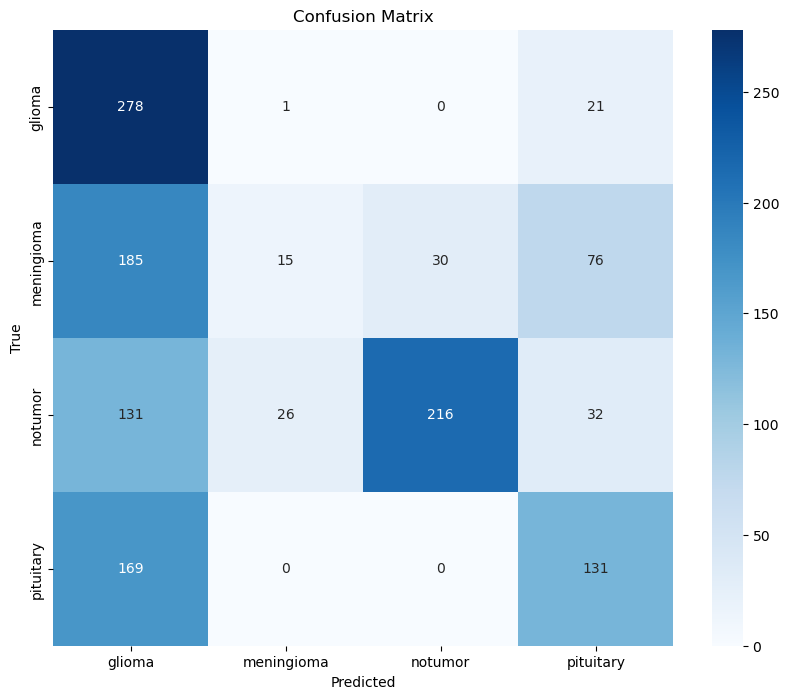

In [10]:
# Evaluate the Model

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.2%}")

# Predictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

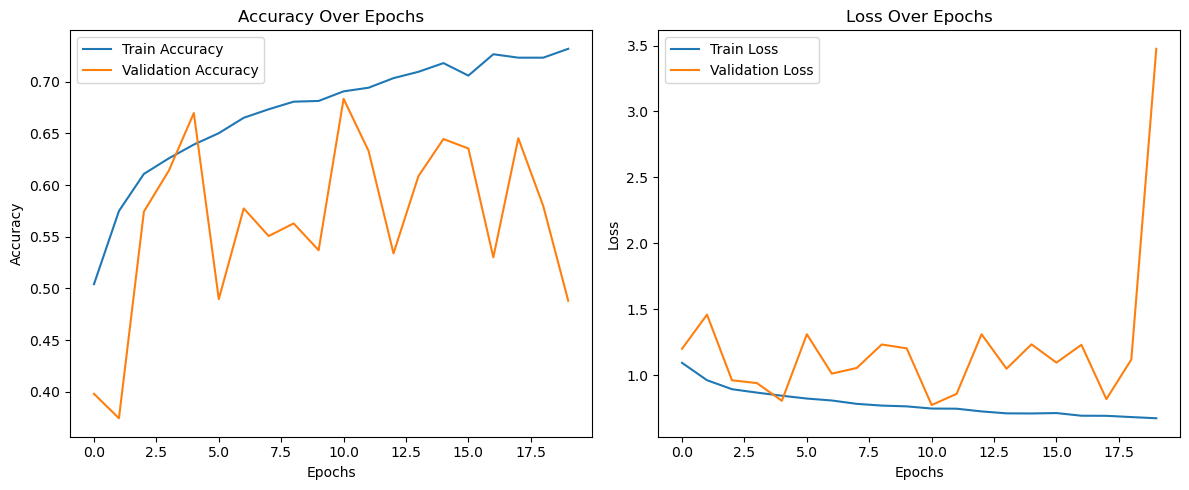

In [11]:
# Visualize Training History

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

C:\Users\milto\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\milto\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_175
Received: inputs=['Tensor(shape=(10, 256, 256, 3))']
  warnings.warn(msg)
C:\Users\milto\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_175
Received: inputs=['Tensor(shape=(20, 256, 256, 3))']
  warnings.warn(msg)


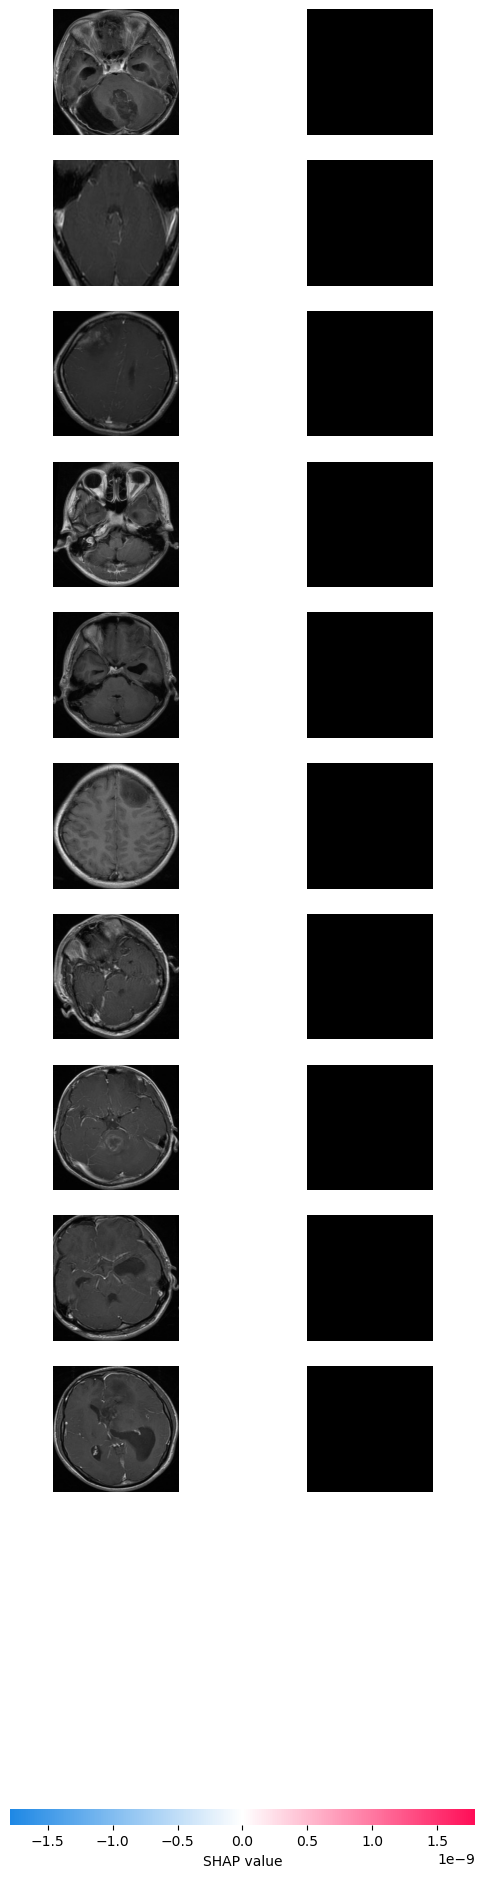

In [12]:
# Explainable AI with SHAP

# SHAP requires a small batch of test data
shap_sample_data, _ = next(test_generator)
shap_sample_data = shap_sample_data[:10]  # Use 10 images for SHAP

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, shap_sample_data)
shap_values = explainer.shap_values(shap_sample_data)

# Visualize SHAP values
shap.image_plot(shap_values, shap_sample_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

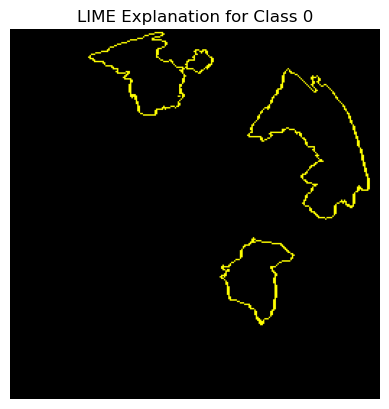

In [13]:
# Explainable AI with LIME

def lime_explain(model, data, sample_index):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        data[sample_index].astype('double'),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for Class {explanation.top_labels[0]}")
    plt.axis('off')
    plt.show()

# Run LIME on a sample
lime_explain(model, shap_sample_data, 0)

In [14]:
# Better Generalization: Pre-trained models and class weights should improve classification metrics.
# Balanced Predictions: Class weights and better data augmentation mitigate bias toward dominant classes.
# Explainability: SHAP and LIME provide insights into predictions, helping refine preprocessing or model training.

Loading pituitary: 100%|██████████| 300/300 [00:00<00:00, 989.54it/s] 



Data Distribution:
Class
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


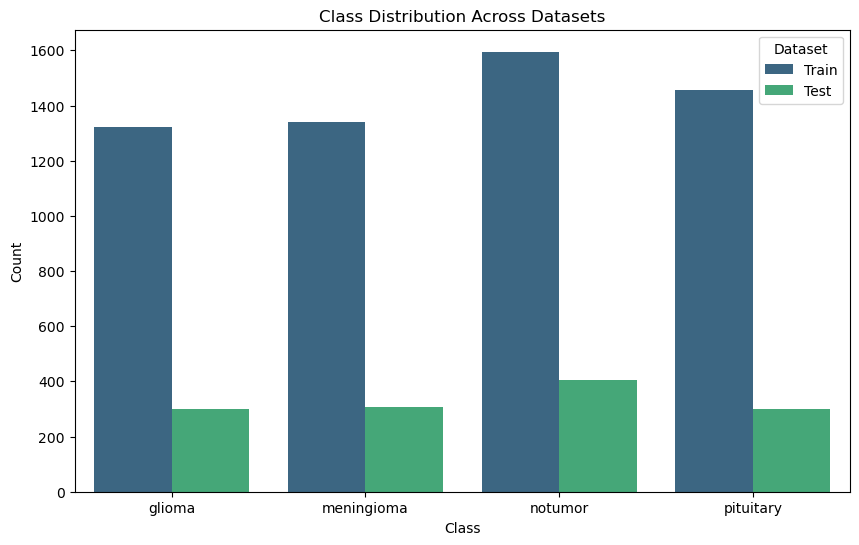

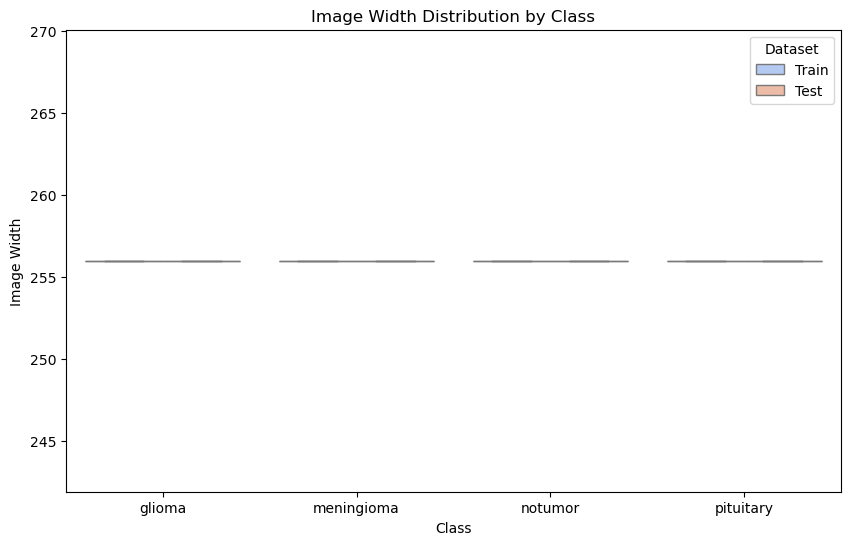

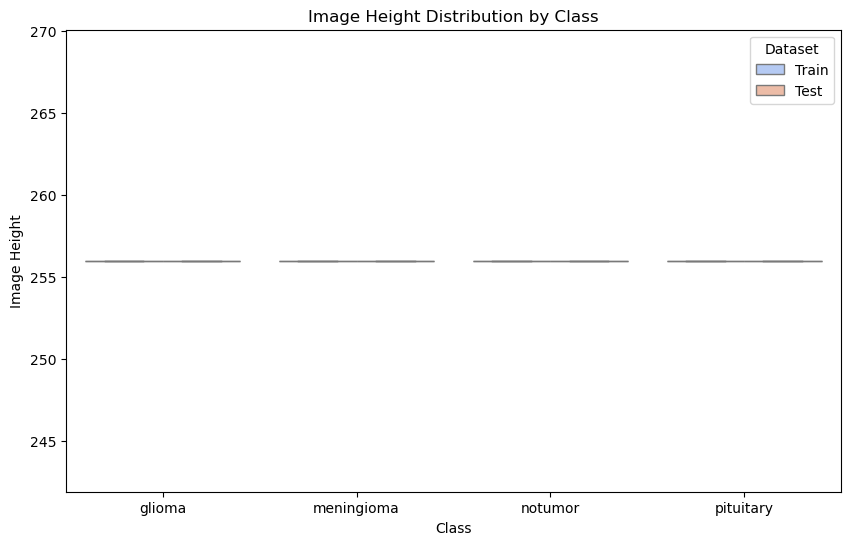

C:\Users\milto\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\milto\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


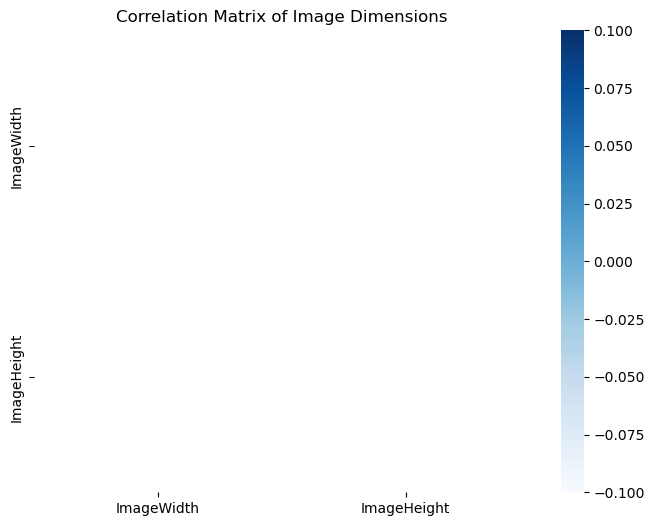

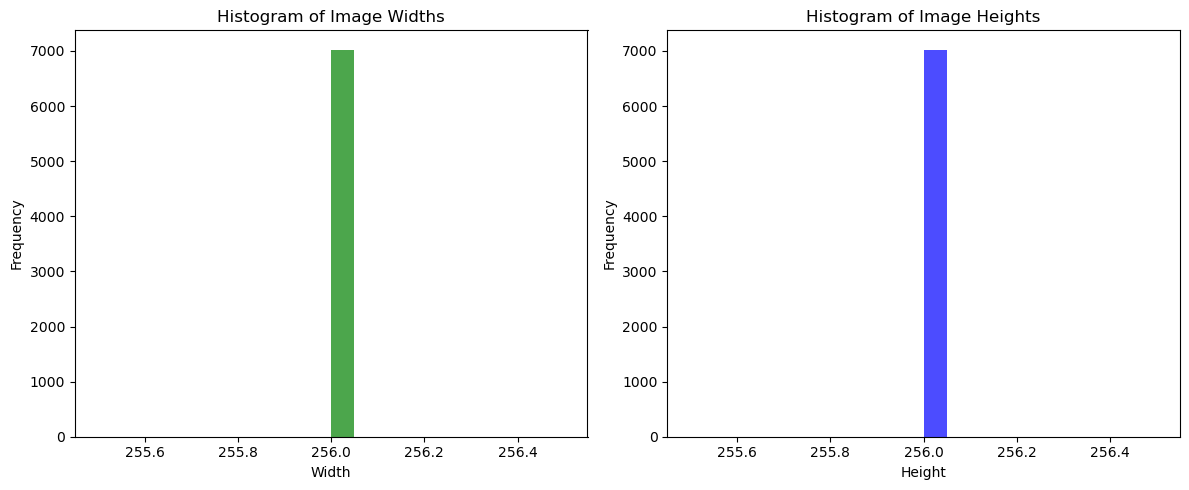


Preliminary Insights:
Total Classes: 4
Class Names: ['glioma' 'meningioma' 'notumor' 'pituitary']
Most Frequent Class: notumor
Least Frequent Class: glioma


In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define paths for the dataset
training_path = 'Cleaned_Training'
testing_path = 'Cleaned_Testing'

# Function to load image metadata
def load_image_data(path):
    class_labels = []
    image_sizes = []

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        for img_name in tqdm(os.listdir(subfolder_path), desc=f"Loading {subfolder}"):
            img_path = os.path.join(subfolder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                class_labels.append(subfolder)
                image_sizes.append(img.shape[:2])

    return pd.DataFrame({
        'Class': class_labels,
        'ImageWidth': [size[1] for size in image_sizes],
        'ImageHeight': [size[0] for size in image_sizes]
    })

# Load data for training and testing
train_data = load_image_data(training_path)
test_data = load_image_data(testing_path)

# Combine train and test data
all_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test')])

# Summary of data distribution
print("\nData Distribution:")
print(all_data['Class'].value_counts())

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=all_data, x='Class', hue='Dataset', palette='viridis')
plt.title('Class Distribution Across Datasets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plot image dimensions distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_data, x='Class', y='ImageWidth', hue='Dataset', palette='coolwarm')
plt.title('Image Width Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Image Width')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=all_data, x='Class', y='ImageHeight', hue='Dataset', palette='coolwarm')
plt.title('Image Height Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Image Height')
plt.show()

# Correlation matrix of image dimensions
correlation_matrix = all_data[['ImageWidth', 'ImageHeight']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix of Image Dimensions')
plt.show()

# Generate histograms for image dimensions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_data['ImageWidth'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(all_data['ImageHeight'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Preliminary Insights
print("\nPreliminary Insights:")
print(f"Total Classes: {all_data['Class'].nunique()}")
print(f"Class Names: {all_data['Class'].unique()}")
print(f"Most Frequent Class: {all_data['Class'].value_counts().idxmax()}")
print(f"Least Frequent Class: {all_data['Class'].value_counts().idxmin()}")
